In [1]:
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from multiprocessing import Pool
from itertools import product
import os
import pickle

***set basic parameters***

In [2]:
stimulus_duration = 500  # ms
release_duration = 6  # ms
starting_pool_size = 20
max_pool_size = 20
max_fraction_release = 0.75  # Maximal fraction of a full pool expected to be released following a spike, when allowed for the longest release duration
time_to_max_probability = 1  # ms
initial_probability = 0
longest_release_duration = 9  # ms
dt_ms = 0.01  # ms

time_bins = np.arange(0 + dt_ms, stimulus_duration + dt_ms, dt_ms)

*Function definitions*

In [3]:
## Revised functions for beta value generation
def nu_beta_params(beta_mode: float, beta_span: float=15,
                    mode_centrality: float=3, decay_velocity: float=2,
                   return_parmas=False) -> tuple:
    """
    This function is used to derive the beta distribution A and B parameters
    for the customized heavy tailed beta_distribution

    :param beta_span: Maximal stimulus_duration of the heavy tailed beta distribution
    :param beta_mode: The mode of the distribution
    :param mode_centrality: Parameter controlling how tight the probability distribution is around the mode - Higher values will result in more values closer to the mode
    :param decay_velocity: Parameter controlling how fast the probability decays after the mode, higher values will lead to less extreme values
    """
    # Calculate parameters for beta distribution
    beta_a = 1 + (mode_centrality / beta_span) * (decay_velocity - 1)
    beta_b = (beta_span * (beta_a - 1) - beta_mode * (beta_a - 2)) / beta_mode

    # Create scipy distribution object to represent beta distribution
    beta_dist = beta(a=beta_a, b=beta_b, scale=beta_span)

    if return_parmas:
        return beta_dist, beta_a, beta_b
    else:
        return beta_dist


def nu_beta_bins(release_duration, beta_dist,
                 dt_ms=1e-2, time_bins=[]):
    """
    This function is used to generate the possible vesicle release times, along with
    the probablities of release for each possible release time
    """

    if not any(time_bins):# Create time bins
        bin_borders = np.arange(0 + dt_ms, release_duration + dt_ms, dt_ms)  # Create border values in specified range
        time_bins = bin_borders[:-1] + (dt_ms / 2)  # Find centers between each each two borders
    else:
        bin_borders = np.array([*np.r_[time_bins - (dt_ms / 2)], time_bins[-1] + (dt_ms / 2)])
    # Calculate probability for each possible time value
    probabilities = beta_dist.cdf(bin_borders[1:]) - beta_dist.cdf(bin_borders[:-1])

    # Retain only bins within the possible release stimulus_duration
    possible_inds = time_bins <= release_duration
    time_bins = time_bins[possible_inds]
    probabilities = probabilities[possible_inds]

    return probabilities, time_bins

*Test stimulus generation*

In [4]:
frequency = 15
neuron = time_bins[np.random.rand(time_bins.shape[0]) <= (frequency * dt_ms / 1000)]  # These are the spike times for this neuron

The original beta function used with the independent pool stochastic release  
essentially outputs the probability of exactly one vesicle being released  
at a single instant in time, we denoth this probability $P_1$.

marking the independent probability of release for any vesicle as $p$,  
and for a maximal $n$ number of vesicles being released we get:
$$
eq_1:   P_1(t)=n\times(p(t)\times(1-p(t))^{n-1})
$$  

we now turn into deriving the value of $p$ from the function we already have  
for generating $P_1$

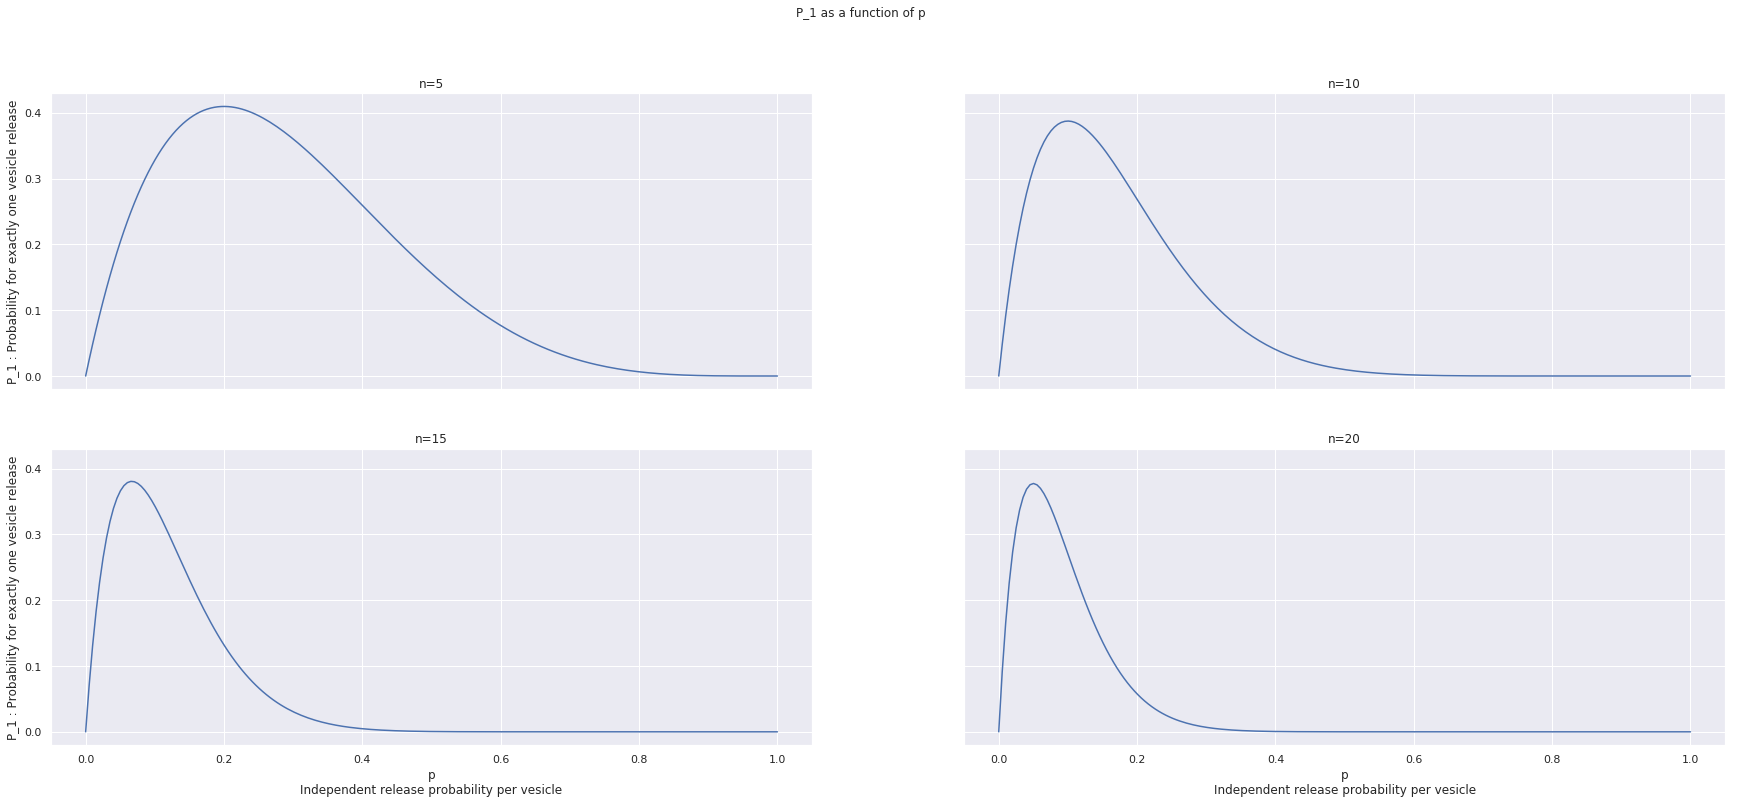

In [5]:
n_values = np.round(np.r_[0.25, 0.5, 0.75, 1] * max_pool_size).astype(int)
p_values = np.linspace(0, 1, 200)
fig, axarr = plt.subplots(2,2, sharex=True, sharey=True, figsize=(30,12), squeeze=True)
for ax, n in zip(np.r_[axarr].flatten(), n_values):
    P1_p = n * p_values * (1 - p_values)**(n-1)
    ax.plot(p_values, P1_p)
    ax.set_title(f'n={n}')
for ax in axarr[1]:
    ax.set_xlabel('p\nIndependent release probability per vesicle')
for ax in [ax_[0] for ax_ in axarr]:
    ax.set_ylabel('P_1 : Probability for exactly one vesicle release')

fig.suptitle('P_1 as a function of p');

Attempting to derive scaling factor for p

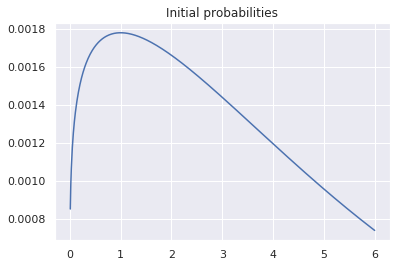

In [6]:
beta_dist = nu_beta_params(beta_mode=time_to_max_probability)
initial_probabilities, _ = nu_beta_bins(release_duration, beta_dist, dt_ms=dt_ms, time_bins=time_bins)
release_times = np.arange(0 + dt_ms, release_duration + dt_ms, dt_ms)
plt.plot(release_times, initial_probabilities)
plt.title('Initial probabilities');

We begin by creating a beta distribution and deriving $P_1$ probability values for all  
possible time bins as done before

In [7]:
beta_dist = nu_beta_params(beta_mode=time_to_max_probability)
initial_probabilities, _ = nu_beta_bins(release_duration, beta_dist, dt_ms=dt_ms, time_bins=time_bins)
P_1_scaling_factor = max_pool_size * beta_dist.cdf(longest_release_duration)

P_1 = initial_probabilities * P_1_scaling_factor

Now we use the expression from $eq_1$ to iteratively calculate the value of p at each time bin

In [12]:
import sympy as sym
p_, P_1_, n_ = sym.symbols(['p', 'P_1', 'n'], positive=True, real=True)
def f(n, t, P):
#     n, t, P = conds
    print(f'\r[n={n}] | P({t:.3f}) = {P:.4f}', flush=True, end='')
    sol = sym.solve([p_ >=0, p_<=1, 
                     n * (p_ * (1 - p_) ** (n - 1)) - P], 
                    p_, quick=True)
    return [t , sol]
    

In [13]:
p = {n: [] for n in n_values}
for n in n_values:
    file_name = f'{n}_ves_unordered'
    if not os.path.exists(file_name):
        print(f'\rworking on {n} vesicles')
        conds = product([n], zip(release_times, P_1))
        conds = [[c[0], c[1][0], c[1][1]] for c in conds]
        with Pool(8) as POOL:
            res = POOL.starmap(f, conds)
        p[n] = res
        with open(file_name, 'wb') as file:
            pickle.dump(res, file, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print(f'{n} vesicles already done!')
        with open(file_name, 'rb') as file:
            p[n] = pickle.load(file)

for key, values in p.items():
    p[key] = np.array([[y[0], y[1].args[0].args[1]] for y in values]).astype(float)

working on 5 vesicles
working on 10 vesicles
working on 15 vesicles
working on 20 vesicles
[n=20] | P(5.890) = 0.0146

In [10]:
df = pd.DataFrame(np.zeros((release_times.shape[0], n_values.shape[0])), index=release_times, columns=n_values)

plt.figure(figsize=(18,6))
for n in n_values:
    df.loc[p[n][:, 0], n] = p[n][:, 1]
    plt.plot(release_times, df[n], label=f'{n}')
df.to_csv('all_ordered.csv')
plt.ylabel('p - independent release probability')
plt.xlabel('Time from action potential (ms)')
plt.title(f'Values obtained with release duration of {release_duration}')
plt.legend();

IndexError: too many indices for array